In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from itertools import product
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [21]:
# set up initial path to data
DATADIR = os.path.join("sample-data","data")
game_id = 1 # let's look at sample match 2

In [22]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

In [23]:
# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)

In [24]:
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

Reading team: home
Reading team: away


In [25]:
passes = events.loc[events["Type"]=="PASS"]
passes.insert(2,"Impact Factor",0)##Set up a column for the impact factor to go into

In [26]:
passes

,Team,Type,Impact Factor,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,Away,PASS,0,NaN,1,1,0.04,3,0.12,Player19,Player21,-5.30,7.48,5.30,4.76
2,Away,PASS,0,NaN,1,3,0.12,17,0.68,Player21,Player15,5.30,4.76,8.48,19.72
3,Away,PASS,0,NaN,1,45,1.80,61,2.44,Player15,Player19,5.30,21.08,-5.30,12.92
4,Away,PASS,0,NaN,1,77,3.08,96,3.84,Player19,Player21,-5.30,12.24,-1.06,2.04
5,Away,PASS,0,NaN,1,191,7.64,217,8.68,Player21,Player22,-10.60,-15.64,-19.08,-32.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,Away,PASS,0,NaN,2,142715,5708.60,142755,5710.20,Player20,Player27,-9.54,11.56,10.60,31.28
1736,Away,PASS,0,NaN,2,143130,5725.20,143137,5725.48,Player16,Player18,0.00,8.84,11.66,-2.04
1739,Home,PASS,0,NaN,2,143262,5730.48,143297,5731.88,Player14,Player12,26.50,19.04,22.26,14.96
1740,Home,PASS,0,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,10.60,11.56,-32.86,-30.60


In [27]:
def find_pass_indexes(df):##Find the indexes for all the passes since they are not sequential
    index = []
    for i in range(0, len(df)):
        index.append(df.loc[df['Type'] == 'PASS'].index[i])
    return index
pass_indexes=find_pass_indexes(passes)

print(len(pass_indexes))##

799


In [86]:
threshold=10
for i in range(0,len(pass_indexes)):
    pass_number=pass_indexes[i]##Update: Problem solved
    pass_of_interest_loc_before=passes.loc[pass_number].at["Start Frame"]
    pass_of_interest_team=passes.loc[pass_number].at["Team"]
##Lets get the tracking data from before the pass is made and find how many teammates were open
    if pass_of_interest_team=="Away":
        reciever_teammates_before=tracking_away.loc[pass_of_interest_loc_before][2:26].dropna()##Away has 12 players=>26
        reciever_opponents_before=tracking_home.loc[pass_of_interest_loc_before][2:30].dropna()##Home has 14 players=>30
    else:
        reciever_opponents_before=tracking_away.loc[pass_of_interest_loc_before][2:26].dropna()##Thus these lists will ALWAYS
        reciever_teammates_before=tracking_home.loc[pass_of_interest_loc_before][2:30].dropna()##have 22 entries, GK always in 0,1
    ##Further, we could exclude GK's from this if it makes it better
    teammate_x_before=list(reciever_teammates_before[0:21:2])##Seperate all x and y values and turn into list
    teammate_y_before=list(reciever_teammates_before[1:22:2])##So we can use the zip function to pair up corresponding x values
    opponent_x_before=list(reciever_opponents_before[0:21:2])##made names shorter because it was getting absurd
    opponent_y_before=list(reciever_opponents_before[1:22:2])
    distances_before=[]##initialize the list that will store distances
    for (x1, y1), (x2, y2) in product(zip(teammate_x_before, teammate_y_before), zip(opponent_x_before, opponent_y_before)):
        distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        distances_before.append(distance)
    ##Need to get this so I check if each PLAYER is open
    open_count_before=0##Initialize 
    ##To do this we take 11 elements of distances_before at a time(the distance between the first player in the list and all the player on the other team)
    for i in range(0,11):
        if all(x > threshold for x in distances_before[i*11:(i+1)*11]):##And we check if all those values are greater than a certain number, here: 5
            open_count_before+=1
##Lets get the tracking data from after the pass was made
##This is the same exact process but using the reference of the end frame of the pass rather than the start frame
    pass_of_interest_loc_after=passes.loc[pass_number].at["End Frame"]
    pass_of_interest_team=passes.loc[pass_number].at["Team"]##Should be the same as before##Take this out when compounding code, this is just here as a reminder
    if pass_of_interest_team=="Away":
        reciever_teammates_after=tracking_away.loc[pass_of_interest_loc_after][2:26].dropna()##Away has 12 players=>26
        reciever_opponents_after=tracking_home.loc[pass_of_interest_loc_after][2:30].dropna()##Home has 14 players=>30
    else:
        reciever_opponents_after=tracking_away.loc[pass_of_interest_loc_after][2:26].dropna()##Thus these lists will ALWAYS
        reciever_teammates_after=tracking_home.loc[pass_of_interest_loc_after][2:30].dropna()##have 22 entries, GK always in 0,1
    ##Further, we could exclude GK's from this if it makes it better
##Get the distances for after
    teammate_x_after=list(reciever_teammates_after[0:21:2])
    teammate_y_after=list(reciever_teammates_after[1:22:2])
    opponent_x_after=list(reciever_opponents_after[0:21:2])
    opponent_y_after=list(reciever_opponents_after[1:22:2])
    distances_after=[]##initialize the list
    for (x1,y1), (x2,y2) in product(zip(teammate_x_after,teammate_y_after), zip(opponent_x_after, opponent_y_after)):
        distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        distances_after.append(distance)


    open_count_after=0##Initialize 
##To do this we take 11 elements of distances_before at a time(the distance between the first player in the list and all the player on the other team)

    for i in range(0,11):
        if all(x > threshold for x in distances_after[i*11:(i+1)*11]):##And we check if all those values are greater than a certain number, here: 5
            open_count_after+=1
    iFactor=open_count_after-open_count_before ##Find how many teammates were made open by the pass
    passes.loc[pass_number,('Impact Factor')]=iFactor##Assign that factor to the corresponding row in the data frame

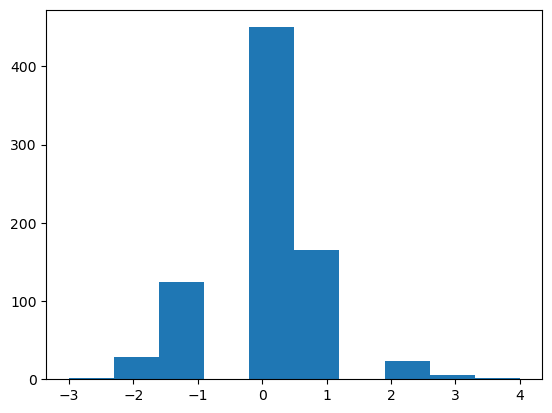

In [87]:
t10=passes["Impact Factor"].describe()
h10=plt.hist(passes["Impact Factor"])

In [88]:
threshold=5
for i in range(0,len(pass_indexes)):
    pass_number=pass_indexes[i]##Update: Problem solved
    pass_of_interest_loc_before=passes.loc[pass_number].at["Start Frame"]
    pass_of_interest_team=passes.loc[pass_number].at["Team"]
##Lets get the tracking data from before the pass is made and find how many teammates were open
    if pass_of_interest_team=="Away":
        reciever_teammates_before=tracking_away.loc[pass_of_interest_loc_before][2:26].dropna()##Away has 12 players=>26
        reciever_opponents_before=tracking_home.loc[pass_of_interest_loc_before][2:30].dropna()##Home has 14 players=>30
    else:
        reciever_opponents_before=tracking_away.loc[pass_of_interest_loc_before][2:26].dropna()##Thus these lists will ALWAYS
        reciever_teammates_before=tracking_home.loc[pass_of_interest_loc_before][2:30].dropna()##have 22 entries, GK always in 0,1
    ##Further, we could exclude GK's from this if it makes it better
    teammate_x_before=list(reciever_teammates_before[0:21:2])##Seperate all x and y values and turn into list
    teammate_y_before=list(reciever_teammates_before[1:22:2])##So we can use the zip function to pair up corresponding x values
    opponent_x_before=list(reciever_opponents_before[0:21:2])##made names shorter because it was getting absurd
    opponent_y_before=list(reciever_opponents_before[1:22:2])
    distances_before=[]##initialize the list that will store distances
    for (x1, y1), (x2, y2) in product(zip(teammate_x_before, teammate_y_before), zip(opponent_x_before, opponent_y_before)):
        distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        distances_before.append(distance)
    ##Need to get this so I check if each PLAYER is open
    open_count_before=0##Initialize 
    ##To do this we take 11 elements of distances_before at a time(the distance between the first player in the list and all the player on the other team)
    for i in range(0,11):
        if all(x > threshold for x in distances_before[i*11:(i+1)*11]):##And we check if all those values are greater than a certain number, here: 5
            open_count_before+=1
##Lets get the tracking data from after the pass was made
##This is the same exact process but using the reference of the end frame of the pass rather than the start frame
    pass_of_interest_loc_after=passes.loc[pass_number].at["End Frame"]
    pass_of_interest_team=passes.loc[pass_number].at["Team"]##Should be the same as before##Take this out when compounding code, this is just here as a reminder
    if pass_of_interest_team=="Away":
        reciever_teammates_after=tracking_away.loc[pass_of_interest_loc_after][2:26].dropna()##Away has 12 players=>26
        reciever_opponents_after=tracking_home.loc[pass_of_interest_loc_after][2:30].dropna()##Home has 14 players=>30
    else:
        reciever_opponents_after=tracking_away.loc[pass_of_interest_loc_after][2:26].dropna()##Thus these lists will ALWAYS
        reciever_teammates_after=tracking_home.loc[pass_of_interest_loc_after][2:30].dropna()##have 22 entries, GK always in 0,1
    ##Further, we could exclude GK's from this if it makes it better
##Get the distances for after
    teammate_x_after=list(reciever_teammates_after[0:21:2])
    teammate_y_after=list(reciever_teammates_after[1:22:2])
    opponent_x_after=list(reciever_opponents_after[0:21:2])
    opponent_y_after=list(reciever_opponents_after[1:22:2])
    distances_after=[]##initialize the list
    for (x1,y1), (x2,y2) in product(zip(teammate_x_after,teammate_y_after), zip(opponent_x_after, opponent_y_after)):
        distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        distances_after.append(distance)


    open_count_after=0##Initialize 
##To do this we take 11 elements of distances_before at a time(the distance between the first player in the list and all the player on the other team)

    for i in range(0,11):
        if all(x > threshold for x in distances_after[i*11:(i+1)*11]):##And we check if all those values are greater than a certain number, here: 5
            open_count_after+=1
    iFactor=open_count_after-open_count_before ##Find how many teammates were made open by the pass
    passes.loc[pass_number,('Impact Factor')]=iFactor##Assign that factor to the corresponding row in the data frame

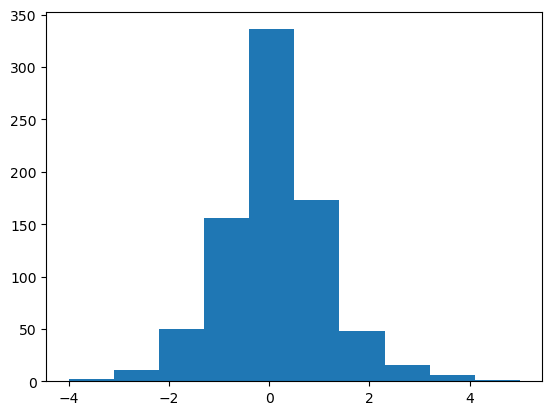

In [89]:
t5=passes["Impact Factor"].describe()
h5=plt.hist(passes["Impact Factor"])

In [97]:
threshold=1
for i in range(0,len(pass_indexes)):
    pass_number=pass_indexes[i]##Update: Problem solved
    pass_of_interest_loc_before=passes.loc[pass_number].at["Start Frame"]
    pass_of_interest_team=passes.loc[pass_number].at["Team"]
##Lets get the tracking data from before the pass is made and find how many teammates were open
    if pass_of_interest_team=="Away":
        reciever_teammates_before=tracking_away.loc[pass_of_interest_loc_before][2:26].dropna()##Away has 12 players=>26
        reciever_opponents_before=tracking_home.loc[pass_of_interest_loc_before][2:30].dropna()##Home has 14 players=>30
    else:
        reciever_opponents_before=tracking_away.loc[pass_of_interest_loc_before][2:26].dropna()##Thus these lists will ALWAYS
        reciever_teammates_before=tracking_home.loc[pass_of_interest_loc_before][2:30].dropna()##have 22 entries, GK always in 0,1
    ##Further, we could exclude GK's from this if it makes it better
    teammate_x_before=list(reciever_teammates_before[0:21:2])##Seperate all x and y values and turn into list
    teammate_y_before=list(reciever_teammates_before[1:22:2])##So we can use the zip function to pair up corresponding x values
    opponent_x_before=list(reciever_opponents_before[0:21:2])##made names shorter because it was getting absurd
    opponent_y_before=list(reciever_opponents_before[1:22:2])
    distances_before=[]##initialize the list that will store distances
    for (x1, y1), (x2, y2) in product(zip(teammate_x_before, teammate_y_before), zip(opponent_x_before, opponent_y_before)):
        distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        distances_before.append(distance)
    ##Need to get this so I check if each PLAYER is open
    open_count_before=0##Initialize 
    ##To do this we take 11 elements of distances_before at a time(the distance between the first player in the list and all the player on the other team)
    for i in range(0,11):
        if all(x > threshold for x in distances_before[i*11:(i+1)*11]):##And we check if all those values are greater than a certain number, here: 5
            open_count_before+=1
##Lets get the tracking data from after the pass was made
##This is the same exact process but using the reference of the end frame of the pass rather than the start frame
    pass_of_interest_loc_after=passes.loc[pass_number].at["End Frame"]
    pass_of_interest_team=passes.loc[pass_number].at["Team"]##Should be the same as before##Take this out when compounding code, this is just here as a reminder
    if pass_of_interest_team=="Away":
        reciever_teammates_after=tracking_away.loc[pass_of_interest_loc_after][2:26].dropna()##Away has 12 players=>26
        reciever_opponents_after=tracking_home.loc[pass_of_interest_loc_after][2:30].dropna()##Home has 14 players=>30
    else:
        reciever_opponents_after=tracking_away.loc[pass_of_interest_loc_after][2:26].dropna()##Thus these lists will ALWAYS
        reciever_teammates_after=tracking_home.loc[pass_of_interest_loc_after][2:30].dropna()##have 22 entries, GK always in 0,1
    ##Further, we could exclude GK's from this if it makes it better
##Get the distances for after
    teammate_x_after=list(reciever_teammates_after[0:21:2])
    teammate_y_after=list(reciever_teammates_after[1:22:2])
    opponent_x_after=list(reciever_opponents_after[0:21:2])
    opponent_y_after=list(reciever_opponents_after[1:22:2])
    distances_after=[]##initialize the list
    for (x1,y1), (x2,y2) in product(zip(teammate_x_after,teammate_y_after), zip(opponent_x_after, opponent_y_after)):
        distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        distances_after.append(distance)


    open_count_after=0##Initialize 
##To do this we take 11 elements of distances_before at a time(the distance between the first player in the list and all the player on the other team)

    for i in range(0,11):
        if all(x > threshold for x in distances_after[i*11:(i+1)*11]):##And we check if all those values are greater than a certain number, here: 5
            open_count_after+=1
    iFactor=open_count_after-open_count_before ##Find how many teammates were made open by the pass
    passes.loc[pass_number,('Impact Factor')]=iFactor##Assign that factor to the corresponding row in the data frame

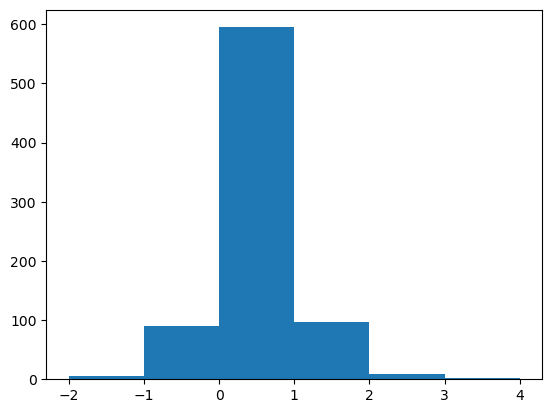

In [103]:
t1=passes["Impact Factor"].describe()
h1=plt.hist(passes["Impact Factor"],bins=[-2,-1,0,1,2,3,4])


In [81]:
print(t10)

count    799.000000
mean       0.052566
std        0.847961
min       -3.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: Impact Factor, dtype: float64


In [82]:
print(t5)

count    799.000000
mean       0.061327
std        1.181518
min       -4.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: Impact Factor, dtype: float64


In [83]:
print(t1)

count    799.000000
mean       0.031289
std        0.588335
min       -2.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: Impact Factor, dtype: float64


NameError: name 'show' is not defined